In [1]:
import pandas as pd
train = pd.read_excel('train.xlsx')

#### 1.	Perform a preliminary data inspection and Data cleaning
    a.	Check for missing data and formulate apt strategy to treat them.
    b.	Are there any duplicate data records? Remove them if present.
    c.	Perform Descriptive analytics on the given data.


In [2]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 379336 entries, 0 to 379335
Data columns (total 8 columns):
InvoiceNo      379336 non-null object
StockCode      379336 non-null object
Description    378373 non-null object
Quantity       379336 non-null int64
InvoiceDate    379336 non-null datetime64[ns]
UnitPrice      379336 non-null float64
CustomerID     285076 non-null float64
Country        379336 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 23.2+ MB


In [3]:
train.isnull().sum()

InvoiceNo          0
StockCode          0
Description      963
Quantity           0
InvoiceDate        0
UnitPrice          0
CustomerID     94260
Country            0
dtype: int64

In [9]:
train.dropna(subset=['CustomerID'], inplace = True)

In [10]:
train.duplicated().sum()

2656

In [12]:
train.drop_duplicates(inplace = True)

In [13]:
train.describe()

Quantity      UnitPrice     CustomerID
count  282420.000000  282420.000000  282420.000000
mean       12.110283       3.526323   15283.894880
std       297.109127      80.691250    1712.665383
min    -80995.000000       0.000000   12346.000000
25%         2.000000       1.250000   13952.000000
50%         5.000000       1.950000   15150.000000
75%        12.000000       3.750000   16788.000000
max     80995.000000   38970.000000   18287.000000

In [14]:
# quantity cannot be negative... so removing the negative quantity records
train = train[train.Quantity >0]
train.describe()


Quantity      UnitPrice     CustomerID
count  276221.000000  276221.000000  276221.000000
mean       13.249767       3.116764   15290.227072
std       214.731317      19.735168    1712.202842
min         1.000000       0.000000   12346.000000
25%         2.000000       1.250000   13969.000000
50%         6.000000       1.950000   15152.000000
75%        12.000000       3.750000   16791.000000
max     80995.000000    4161.060000   18287.000000

#### 2.	Cohort Analysis: A cohort is a group of subjects who share a defining characteristic. We can observe how a cohort behaves across time and compare it to other cohorts. 
    a.	Create month cohorts and analyse active  customers for each cohort.
    b.	Also Analyse the retention rate of customers. Comment.


In [44]:
# cohort month is the month in which the customer bought any item for the first time

In [56]:
import datetime as dt
def get_month(x) : return dt.datetime(x.year,x.month,1)
train['InvoiceMonth'] = train['InvoiceDate'].apply(get_month)
group = df.groupby('CustomerID')['InvoiceMonth']
train['CohortMonth'] = group.transform('min')

In [57]:
train.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'InvoiceMonth', 'CohortMonth'],
      dtype='object')

In [15]:
df = train.copy()

In [73]:
diff = rd.relativedelta(train.InvoiceMonth[1], train.CohortMonth[1])
diff.months

4

In [74]:
from dateutil import relativedelta as rd
def months(date1,date2):
    diff = rd.relativedelta(date1,date2)
    return diff.years*12 +diff.months

In [80]:
# find cohort index is the month passed since first purchase
train['CohortIndex']  = train.apply(lambda row : months(row.InvoiceMonth,row.CohortMonth)+1,axis =1)

In [81]:
train[['CustomerID','CohortIndex','InvoiceMonth','CohortMonth']].head()

CustomerID  CohortIndex InvoiceMonth CohortMonth
1     16126.0            5   2011-06-01  2011-02-01
2     18118.0            6   2011-05-01  2010-12-01
3     15529.0            2   2011-01-01  2010-12-01
4     14448.0            1   2010-12-01  2010-12-01
5     13911.0            4   2011-05-01  2011-02-01

In [135]:
# active monthly customers in each cohort
cohort = train.groupby(['CohortIndex','CohortMonth']).CustomerID.apply(pd.Series.nunique).reset_index()
counts = cohort.pivot(index = 'CohortMonth', columns = 'CohortIndex', values = 'CustomerID' )
retention = counts.divide(counts.iloc[:,0],axis =0).round(3)*100
retention.index = retention.index.date

In [136]:
import seaborn as sns


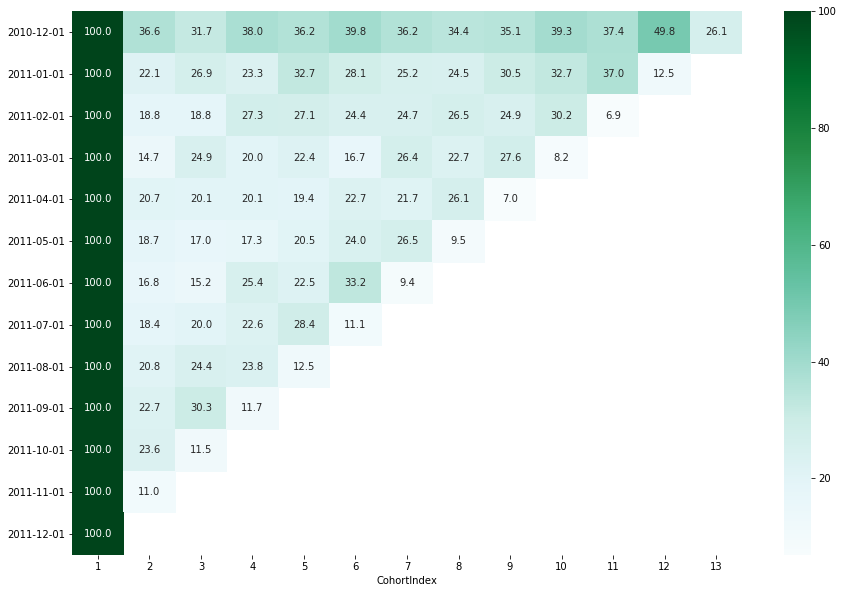

In [137]:
plt.figure(figsize =(15,10))
sns.heatmap(data = retention, annot = True , fmt = '0.1f', cmap = 'BuGn')
plt.show()

In [154]:
# Average Quantity for cohort
quant = train.groupby(['CohortMonth','CohortIndex'])['Quantity'].mean().reset_index()
quant_pivot = quant.pivot(index = 'CohortMonth', columns = 'CohortIndex', values = 'Quantity')
quant_pivot.index = quant_pivot.index.date

plt.figure(figsize = (15,10))
sns.heatmap(data = quant_pivot, annot= True, cmap='BuGn_r',vmin = 0.0,vmax =20)
plt.show()

#### 3.	Build a RFM model – Recency Frequency and Monetary based on their behaviour.
    a.	Calculate RFM metrics.
        i.	Recency as the time in no. of days since last transaction
        ii.	Frequency as  count of purchases done 
        iii.	Monetary value  as total amount spend 
    b.	Build RFM Segments.
        i.	Give Recency Frequency and Monetary scores individually by dividing them in to quartiles.
        ii.	Combine three ratings to get a RFM segment (as strings)
        iii.	Get the RFM score by adding up the three ratings.

In [194]:
train['Total_sum'] = train['UnitPrice'] * train['Quantity']

In [210]:
# for recency : period in days since last transaction for each customer
# for frequency : no. of purchases made
# for monetary : total monetary value

# since this data is from 2011 so lets take the date of analysis as a day more than the last transaction date.
# in real time todays date will be more apt : date_of_analysis = dt.datetime.now().date() 

date_of_analysis = train.InvoiceDate.max().date() + dt.timedelta(days=1)

rfm = train.groupby('CustomerID').agg({'InvoiceDate':lambda x: (date_of_analysis - x.max().date()).days, 
                                       'InvoiceNo':'count',
                                       'Total_sum':'sum'})
rfm.rename(columns = {'InvoiceDate':'Recency','InvoiceNo':'Frequency', 'Total_sum':'MonetaryValue'}, inplace = True)

In [211]:
rfm.head()

Recency  Frequency  MonetaryValue
CustomerID                                   
12346.0         326          1       77183.60
12347.0           3        132        3124.96
12348.0          76         20        1009.88
12349.0          19         50        1344.17
12350.0         311         11         213.30

In [213]:
rfm.describe()

Recency    Frequency  MonetaryValue
count  4321.000000  4321.000000    4321.000000
mean     93.518630    63.925249    1455.075580
std     100.369231   158.847536    6426.698726
min       1.000000     1.000000       0.000000
25%      18.000000    12.000000     209.970000
50%      51.000000    29.000000     479.090000
75%     144.000000    70.000000    1180.080000
max     374.000000  5413.000000  190759.920000

## Looking at the Summary stats we can use quartile limits to divide the data in groups labels
## Either filter and assign values ..
## or use qcut ...

#### for recency : lower value better ---> as person visited the not many days back and thats what org need
#### for frequency and Monetary more the better

In [224]:
rfm['R'] = pd.qcut(rfm['Recency'], q = 4, labels = range(4,0,-1))
rfm['F'] = pd.qcut(rfm['Frequency'], q = 4, labels = range(1,5))
rfm['M'] = pd.qcut(rfm['MonetaryValue'], q = 4, labels = range(1,5))

In [226]:
## create a combined rfm segemnt by combinnig the labels of the three segments
rfm['RFM_segment'] = rfm.R.astype('str') + rfm.F.astype('str') + rfm.M.astype('str')

In [230]:
## create a column by giving RFM score as sum of the labes
rfm['RFM_Score'] = rfm[['R','F','M']].sum(axis = 1)

In [231]:
rfm.head()

Recency  Frequency  MonetaryValue  R  F  M RFM_segment  RFM_Score
CustomerID                                                                   
12346.0         326          1       77183.60  1  1  4         114        6.0
12347.0           3        132        3124.96  4  4  4         444       12.0
12348.0          76         20        1009.88  2  2  3         223        7.0
12349.0          19         50        1344.17  3  3  4         334       10.0
12350.0         311         11         213.30  1  1  2         112        4.0

In [250]:
rfm.drop(['R','F','M'],axis = 1,inplace = True)

In [251]:
# Analyse the segments
rfm.groupby('RFM_segment').size().nlargest(5)

RFM_segment
444    441
111    388
344    213
211    185
122    182
dtype: int64

In [252]:
rfm[rfm.RFM_segment=='111'].head()

Recency  Frequency  MonetaryValue RFM_segment  RFM_Score
CustomerID                                                          
12353.0         205          3          71.30         111        3.0
12361.0         288          7         139.20         111        3.0
12401.0         304          3          58.35         111        3.0
12402.0         324         10         206.10         111        3.0
12441.0         367          8         123.15         111        3.0

In [274]:
rfm_analysis = rfm.groupby('RFM_Score').mean().round(2)
rfm_analysis.insert(0,'size',rfm.groupby('RFM_Score').size())

In [275]:
rfm_analysis

size  Recency  Frequency  MonetaryValue
RFM_Score                                         
3.0         388   260.92       5.91         111.19
4.0         396   178.90       9.92         169.96
5.0         499   145.93      14.16         249.67
6.0         460   102.89      20.08         676.54
7.0         445    83.70      27.82         534.25
8.0         486    61.83      39.64         692.24
9.0         398    47.56      55.62        1439.19
10.0        431    32.89      79.15        1442.24
11.0        377    21.44     134.24        2898.49
12.0        441     7.66     261.21        6530.24

In [289]:
## Group RFM customers into Customer Segments : Silver Gold Platinum based on total RFM_Score :
def seg(Score):
    if Score >= 10:
        return 'Platinum'
    elif Score >= 7:
        return 'Gold'
    else :
        return 'Silver'
rfm['Cust_Seg'] = rfm.RFM_Score.apply(seg)

In [290]:
cust_seg = rfm.groupby('Cust_Seg').mean()
cust_seg.insert(0,'size', rfm.groupby('Cust_Seg').size())

In [291]:
cust_seg = cust_seg.loc[['Platinum','Gold','Silver']]
cust_seg

size     Recency   Frequency  MonetaryValue  RFM_Score
Cust_Seg                                                        
Platinum  1249   20.528423  160.059247    3678.280536  11.008006
Gold      1329   64.877351   40.467269     863.032530   7.964635
Silver    1743  167.660356   12.923695     313.390109   4.591509

#### 4.	Create clusters using k means clustering algorithm.
    a.	Prepare the data for the algorithm.
        i.	If the data is Un Symmetrically distributed, manage the skewness with appropriate transformation.
        ii.	Standardize / scale the data.
    b.	Decide the optimum number of clusters to be formed
    c.	Analyse these clusters and comment on the results
